### Load the Data

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the datasets, ignoring the first column
train_data = pd.read_csv('train.csv',
                         usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary
test_data = pd.read_csv('test.csv',
                        usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary

X_train = train_data[['x', 'y']].values
y_train = train_data['cls'].values

X_test = test_data[['x', 'y']].values
y_test = test_data['cls'].values

### Visualize the Data

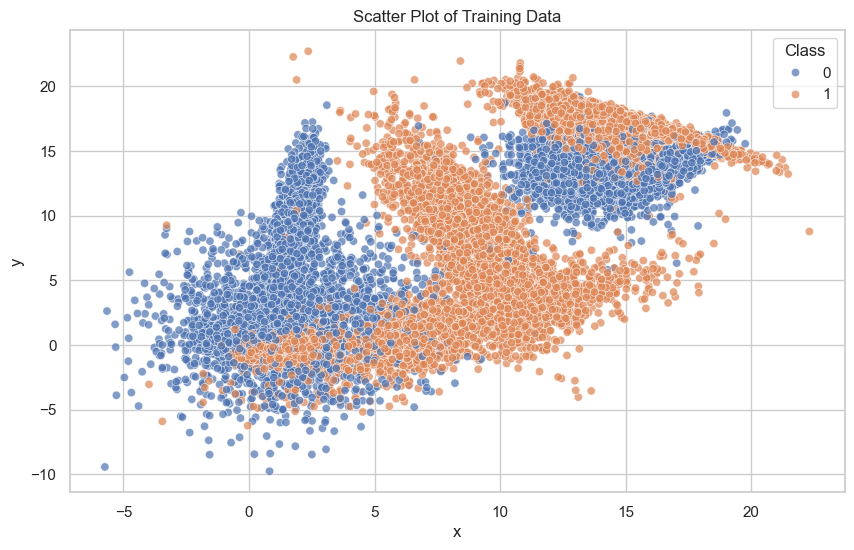

In [3]:
# Set the style of seaborn
sns.set_theme(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='x', y='y', hue='cls', palette='deep', alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Class')
plt.show()


### Analyze the Data

In [4]:
# Check the distribution of classes
class_distribution = train_data['cls'].value_counts()
print(class_distribution)

# Summary statistics of the features
print(train_data.describe())


cls
1    12016
0    11984
Name: count, dtype: int64
                  x             y           cls
count  24000.000000  24000.000000  24000.000000
mean       6.897980      6.840433      0.500667
std        6.638242      6.826364      0.500010
min       -5.739819     -9.763944      0.000000
25%        0.887007      0.421379      0.000000
50%        4.531249      4.941289      1.000000
75%       13.588332     13.693109      1.000000
max       22.312527     22.722494      1.000000


# evaluate model

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on training data
    y_train_pred = model.predict(X_train)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')

    print("Training Metrics:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print()

    # Predict on testing data
    y_test_pred = model.predict(X_test)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    print("Testing Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")


# hyper parameter tuning

In [6]:
def tune_hyperparameters(model, param_grid, X_train, y_train, scoring='accuracy', cv=5):
    print("Starting hyperparameter tuning...")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=4, verbose=1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\nHyperparameter Tuning Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")

    return best_model


### phase1: Bagging

In [20]:
class Bagging:
    def __init__(self, base_model=None, n_estimators=10, random_state=None):
        """
        Custom implementation of the Bagging algorithm.

        Parameters:
        - base_model: The base model (e.g., DecisionTreeClassifier).
        - n_estimators: Number of estimators (default: 10).
        - random_state: Random seed for reproducibility (default: None).
        """
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        self.bootstrap_samples = []

        # Seed for reproducibility
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """
        Fits the Bagging ensemble to the data.

        Parameters:
        - X: Feature matrix (numpy array or pandas DataFrame).
        - y: Target vector (numpy array or pandas Series).
        """
        self.models = []  # Reset models
        self.bootstrap_samples = []  # Reset bootstrap samples

        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            self.bootstrap_samples.append(indices)

            # Train a new base model
            model = self.base_model()
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        """
        Predicts the output for the given feature matrix using majority voting.

        Parameters:
        - X: Feature matrix (numpy array or pandas DataFrame).

        Returns:
        - Predictions (numpy array).
        """
        # Collect predictions from all models
        predictions = np.array([model.predict(X) for model in self.models])
        # Perform majority voting
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return final_predictions
    
    def get_params(self, deep=True):
        return {
            'base_model': self.base_model,
            'n_estimators': self.n_estimators,
            'random_state': self.random_state
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Starting hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Hyperparameter Tuning Complete!
Best Parameters: {'base_model': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'n_estimators': 40, 'random_state': 42}
Best Cross-Validation Score: 0.8579


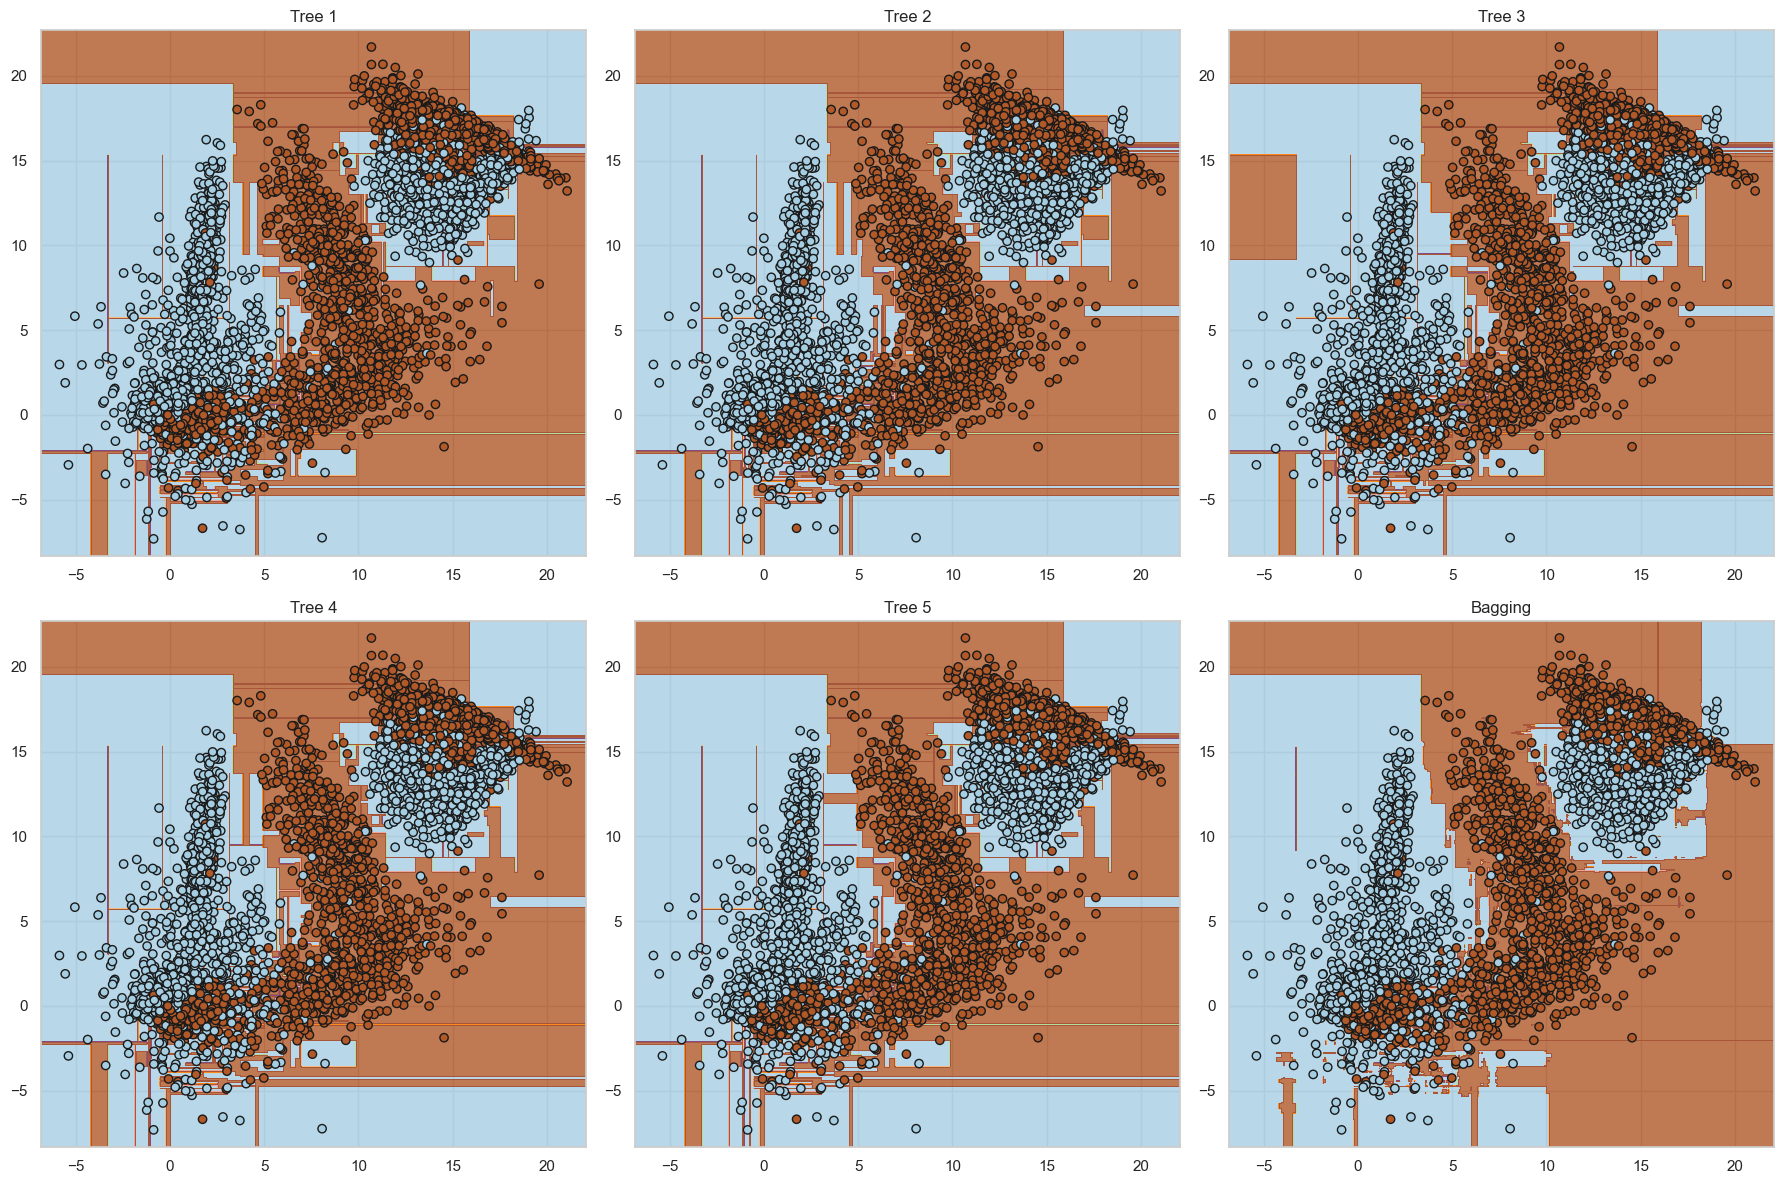

In [21]:
# Train Bagging ensemble
custom_bagging = tune_hyperparameters(Bagging(), {'n_estimators': [10, 20, 30, 40], 'random_state': [42],
                                                  'base_model': [DecisionTreeClassifier]}, X_train, y_train)

# Train 5 individual Decision Trees
trees = []
for i in range(5):
    tree = DecisionTreeClassifier(random_state=42 + i)
    tree.fit(X_train, y_train)
    trees.append(tree)


# Define a function to plot decision boundaries
def plot_decision_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    ax.set_title(title)


# Plot decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Plot each Decision Tree
for i, tree in enumerate(trees):
    plot_decision_boundary(tree, X_test, y_test, f"Tree {i + 1}", axes[i])

# Plot Bagging model
plot_decision_boundary(custom_bagging, X_test, y_test, "Bagging", axes[-1])

plt.tight_layout()
plt.show()


In [22]:
# Train Bagging ensemble using sklearn's BaggingClassifier
sklearn_bagging = tune_hyperparameters(BaggingClassifier(), {
    'n_estimators': [10, 20, 30, 40],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Proportion of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 1.0],  # Proportion of features to draw from X to train each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with replacement
    'estimator': [DecisionTreeClassifier()]  # The base estimator to fit on random subsets of the dataset
},X_train, y_train)
sklearn_bagging.fit(X_train, y_train)

evaluate_model(custom_bagging, X_train, y_train, X_test, y_test)
evaluate_model(sklearn_bagging, X_train, y_train, X_test, y_test)


Starting hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Hyperparameter Tuning Complete!
Best Parameters: {'bootstrap': True, 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 40}
Best Cross-Validation Score: 0.8680
Training Metrics:
Accuracy: 0.9984
F1 Score: 0.9984
Precision: 0.9984
Recall: 0.9984

Testing Metrics:
Accuracy: 0.8553
F1 Score: 0.8553
Precision: 0.8553
Recall: 0.8553
Training Metrics:
Accuracy: 0.9557
F1 Score: 0.9558
Precision: 0.9558
Recall: 0.9557

Testing Metrics:
Accuracy: 0.8603
F1 Score: 0.8603
Precision: 0.8605
Recall: 0.8603


# Phase 2

In [23]:
class RandomForest:
    def __init__(self, n_estimators=10, max_features=None, random_state=None):
        """
        Custom implementation of Random Forest algorithm.
        
        Parameters:
        - n_estimators: Number of decision trees.
        - max_features: Number of features to consider when looking for the best split.
        - random_state: Random seed for reproducibility.
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.bootstrap_samples = []
        self.feature_indices = []
        
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """
        Fits the Random Forest model on the training data.
        
        Parameters:
        - X: Training features (numpy array or pandas DataFrame).
        - y: Training labels (numpy array or pandas Series).
        """
        n_samples, n_features = X.shape
        self.trees = []
        self.bootstrap_samples = []
        self.feature_indices = []

        # Use all features if max_features is not specified
        if self.max_features is None:
            self.max_features = n_features

        for _ in range(self.n_estimators):
            # Bootstrap sample
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            self.bootstrap_samples.append(indices)

            # Random feature selection
            features = np.random.choice(n_features, size=self.max_features, replace=False)
            self.feature_indices.append(features)

            # Train a Decision Tree on the selected features
            tree = DecisionTreeClassifier(random_state=self.random_state)
            tree.fit(X_sample[:, features], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predicts the output using majority voting from all trees.
        
        Parameters:
        - X: Input features (numpy array or pandas DataFrame).
        
        Returns:
        - Predictions (numpy array).
        """
        predictions = []
        for i, tree in enumerate(self.trees):
            predictions.append(tree.predict(X[:, self.feature_indices[i]]))
        
        # Majority voting
        predictions = np.array(predictions).T
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)
        return final_predictions


Custom Random Forest Accuracy: 0.8475
Sklearn Random Forest Accuracy: 0.8492


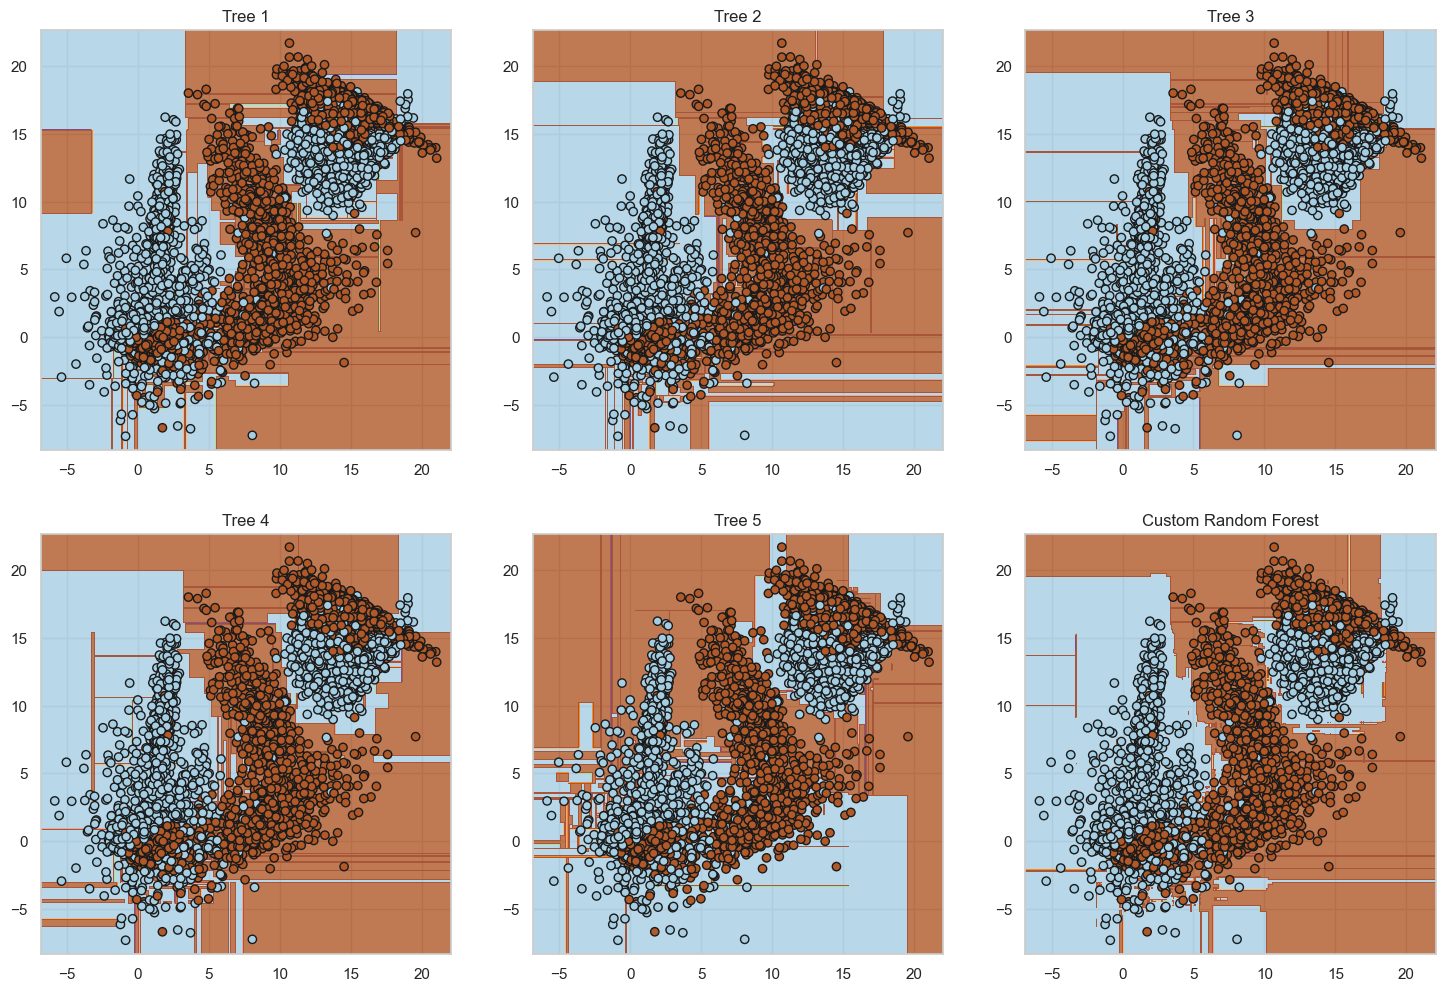

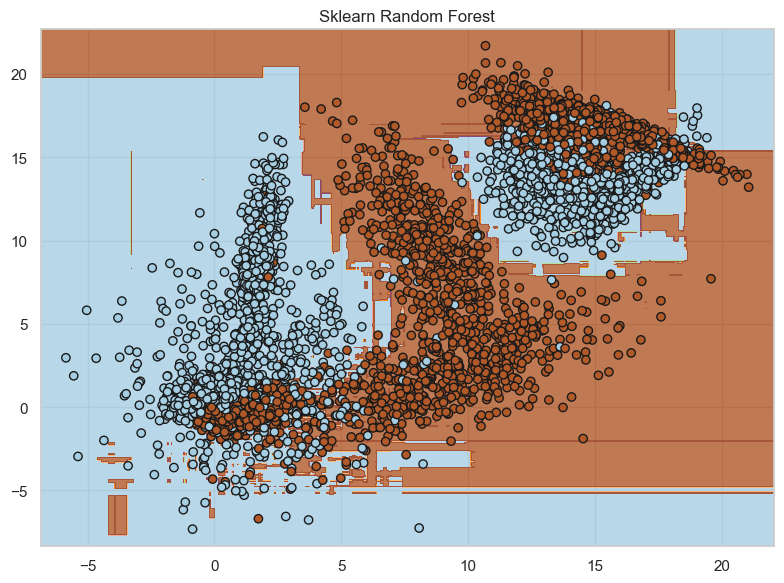

In [26]:
# Train RandomForest (Custom Implementation)
random_forest = RandomForest(n_estimators=10, max_features=2, random_state=42)
random_forest.fit(X_train, y_train)
custom_rf_predictions = random_forest.predict(X_test)

sklearn_rf = RandomForestClassifier(n_estimators=10, max_features=2, random_state=42)
sklearn_rf.fit(X_train, y_train)
sklearn_rf_predictions = sklearn_rf.predict(X_test)

# Evaluate Accuracy
custom_rf_accuracy = accuracy_score(y_test, custom_rf_predictions)
sklearn_rf_accuracy = accuracy_score(y_test, sklearn_rf_predictions)

print(f"Custom Random Forest Accuracy: {custom_rf_accuracy:.4f}")
print(f"Sklearn Random Forest Accuracy: {sklearn_rf_accuracy:.4f}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a grid of Axes
axes = axes.ravel()  # Flatten the array of Axes for easier indexing

# Plot decision boundaries for 5 individual trees
for i in range(5):
    plot_decision_boundary(random_forest.trees[i], X_test, y_test, f"Tree {i+1}", axes[i])

# Plot decision boundary for Custom Random Forest
plot_decision_boundary(random_forest, X_test, y_test, "Custom Random Forest", axes[5])

# Sklearn Random Forest in a separate plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a new figure and Axes
plot_decision_boundary(sklearn_rf, X_test, y_test, "Sklearn Random Forest", ax)

plt.tight_layout()
plt.show()



# phase 3

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

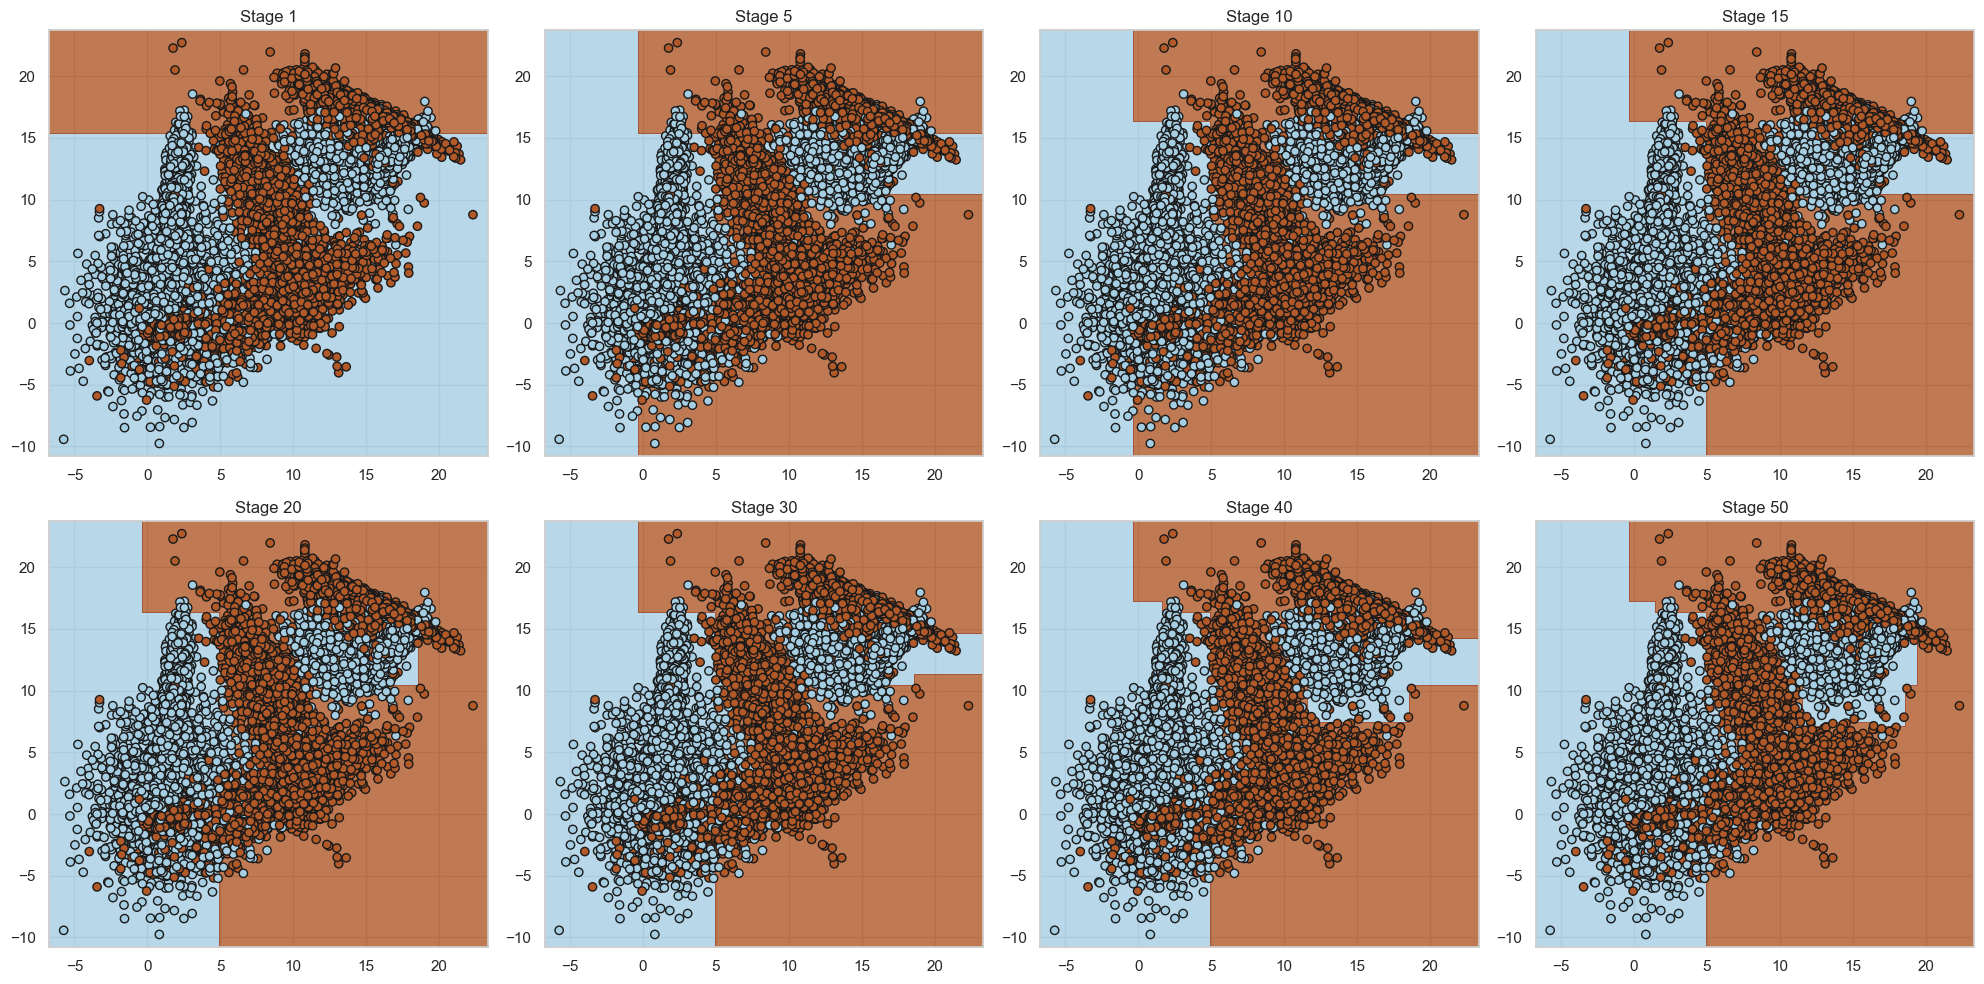

Training Metrics:
Accuracy: 0.8512
F1 Score: 0.8512
Precision: 0.8518
Recall: 0.8512

Testing Metrics:
Accuracy: 0.8470
F1 Score: 0.8469
Precision: 0.8474
Recall: 0.8470


In [28]:
# Train AdaBoostClassifier with a DecisionTreeClassifier as the weak learner
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
adaboost.fit(X_train, y_train)

# Define function to plot decision boundaries
def plot_adaboost_stage(model, X, y, stage, ax):
    """
    Visualizes the decision boundary at a specific stage of AdaBoost.
    """
    model_stage = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=stage,
        random_state=42
    )
    model_stage.fit(X, y)
    
    # Plot decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model_stage.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
    ax.set_title(f"Stage {stage}")

# Visualize 8 selected stages
stages = [1, 5, 10, 15, 20, 30, 40, 50]
fig1, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, stage in enumerate(stages):
    plot_adaboost_stage(adaboost, X_train, y_train, stage, axes[i])

plt.tight_layout()
plt.show()

evaluate_model(adaboost, X_train, y_train, X_test, y_test)


# Phase 4

In [31]:
# Define Base Classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Hyperparameter Tuning
tuned_classifiers = {}
param_grids = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
}

for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy', n_jobs=4)
    grid_search.fit(X_train, y_train)
    tuned_classifiers[name] = grid_search.best_estimator_

# Stacking
def train_stacked_classifier(base_classifiers, meta_classifier, X_train, y_train, X_test, y_test):
    """
    Trains a stacked classifier.
    """
    # Create out-of-fold predictions for base classifiers
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    meta_features_train = np.zeros((X_train.shape[0], len(base_classifiers)))
    meta_features_test = np.zeros((X_test.shape[0], len(base_classifiers)))
    
    for i, (name, clf) in enumerate(base_classifiers.items()):
        fold_predictions = np.zeros((X_test.shape[0], skf.get_n_splits()))
        for j, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            clf_clone = clone(clf)
            clf_clone.fit(X_train[train_idx], y_train[train_idx])
            meta_features_train[val_idx, i] = clf_clone.predict_proba(X_train[val_idx])[:, 1]
            fold_predictions[:, j] = clf_clone.predict_proba(X_test)[:, 1]
        meta_features_test[:, i] = fold_predictions.mean(axis=1)

    # Train meta-classifier
    meta_classifier.fit(meta_features_train, y_train)
    stacked_predictions = meta_classifier.predict(meta_features_test)

    # Evaluate Stacked Model
    accuracy = accuracy_score(y_test, stacked_predictions)
    f1 = f1_score(y_test, stacked_predictions)
    precision = precision_score(y_test, stacked_predictions)
    recall = recall_score(y_test, stacked_predictions)

    return accuracy, f1, precision, recall

# Meta Classifier
meta_classifier = LogisticRegression(random_state=42)

# Train Stacked Classifier
accuracy, f1, precision, recall = train_stacked_classifier(
    tuned_classifiers, meta_classifier, X_train, y_train, X_test, y_test
)

print(f"Stacked Classifier Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Stacked Classifier Metrics:
Accuracy: 0.8717
F1 Score: 0.8735
Precision: 0.8571
Recall: 0.8905
